# 05. RNN(순환 신경망, Recureent Neural Network

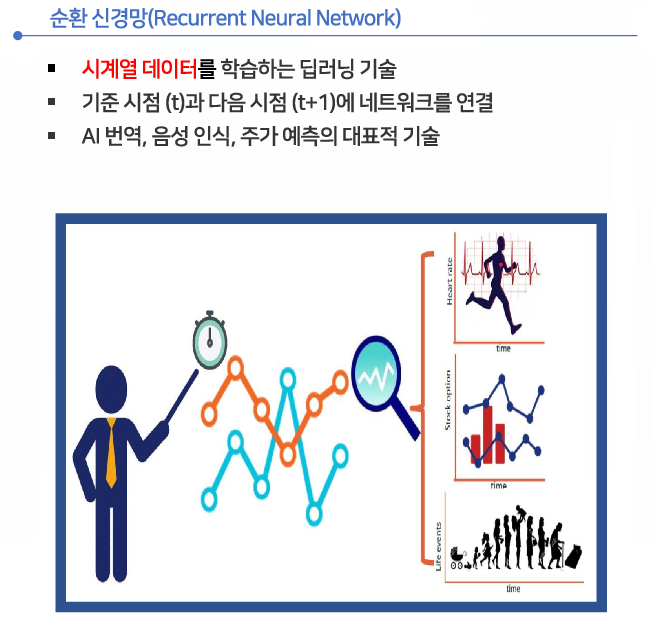

In [1]:
from IPython.display import Image
Image("img/day03_01.png", width=600)

> - 시계열 데이터는 어떤 시점에 만들어지는 것이 내용 만큼 중요하다.
> - 번역기술을 보면 순서가 중요하다. 그러므로 RNN 기술 사용
> - RNN의 구조가 균일하고 모든 단이 같은 구조를 가지고 반복한다.

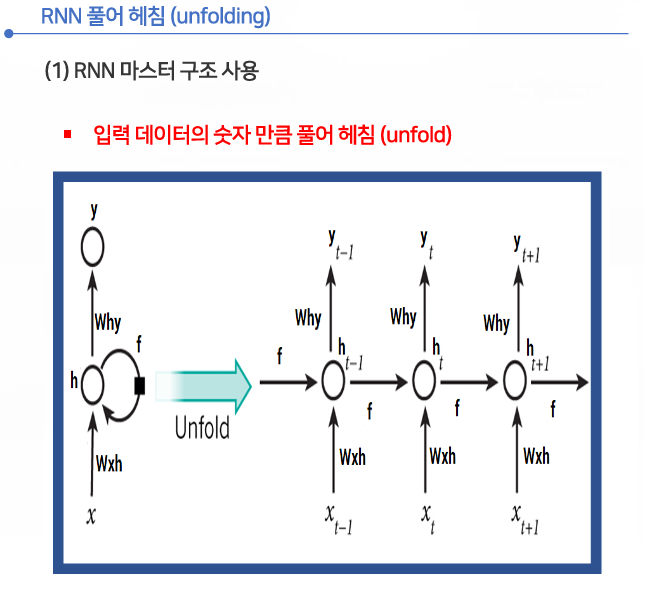

In [2]:
Image("img/day03_02.png", width=600)

> - `h` 는 은닉상태를 나타낸다. (이전 타임스탭의 정보를 가지고 있음 )
> - `x` 는 현재 타임스탭의 입력
> - `f` 는 활성화 함수 (relu 또는 tanh)
> - `t-1` , `t`, `t+1` 각 각의 의미는 이전, 현재, 다음스탭을 나타내다.
> - 시간에 따라 정보가 어떻게 흐르는지 시각화 할 수 있음

### RNN의 동작원리

1. 입력 : 첫번째 타입스탭에서 입력 x가 주어진다.

2. 은닉상태계산 : 입력 x 와 이전 타입스택의 은닉 상태 h를 결합하여 새로운 은닉상태 h를 계산한다.

3. 출력계산 : 새로운 은닉상태 h를 사용하여 출력 y를 계산한다.

4. 반복 : 반복하여 시퀀스의 모든 타임스탭을 처리한다.

####  긴 시퀀스 처리할 때 기울기 손실 문제로 인해 학습이 어려울수 있다. 이를 해결하기 위해서 LSTM이나 GRU를 사용한다.

#### 이미지 캡셔닝 : CNN으로 주어진 이미지에서 사물을 인식하고, RNN으로 문자을 이룬다.

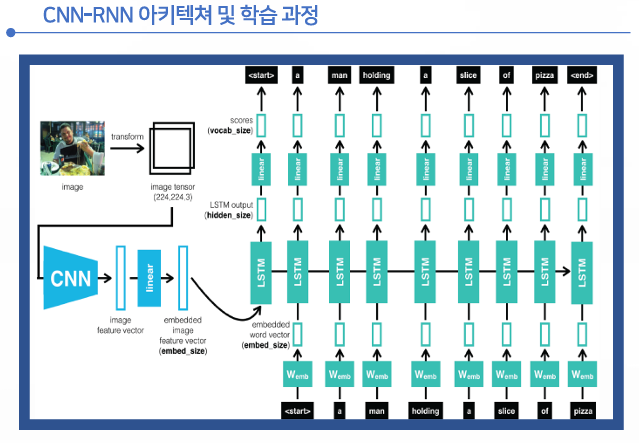

In [3]:
Image("img/day03_03.png", width=600)

#### RNN의 두가지 방향의 의미

1. 밑에서 위로  : 입력 -> 출력

2. 좌에서 우로 : 과거 -> 현재 (시계열)

*** 답이 틀리면 역전파을 한다. (시냅스의 가중치를 경사하강법으로 보정한다.

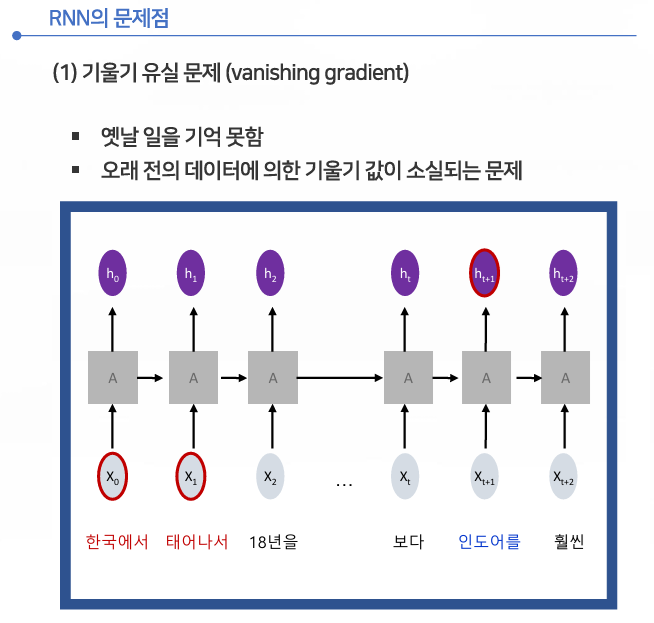

In [4]:
Image("img/day03_04.png", width=600)

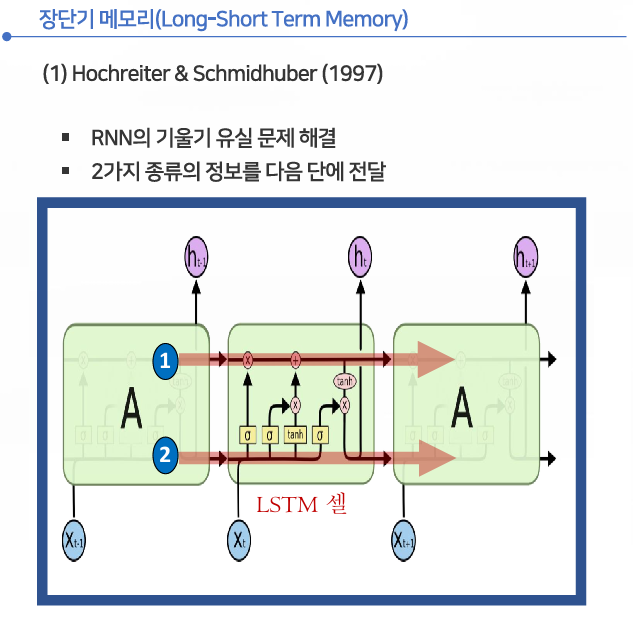

In [5]:
Image("img/day03_05.png", width=600)

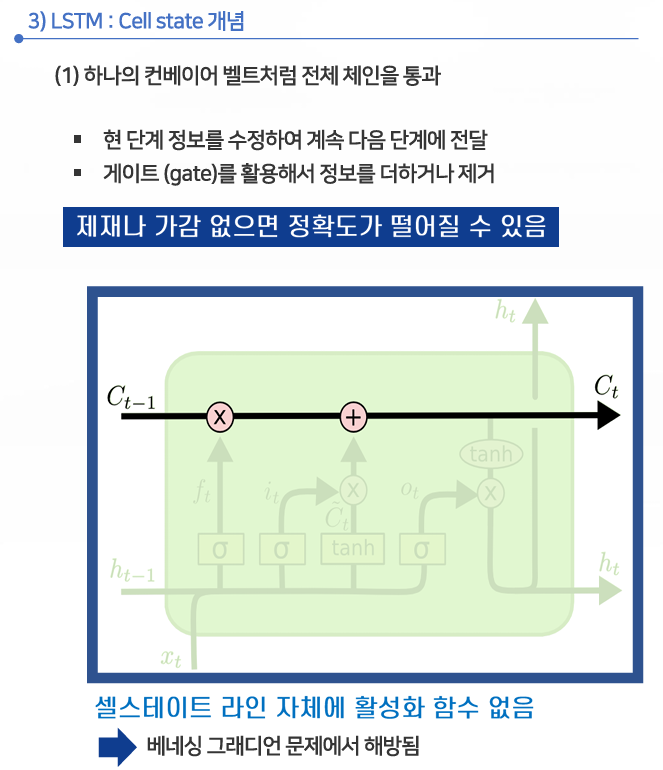

In [6]:
Image("img/day03_06.png", width=600)

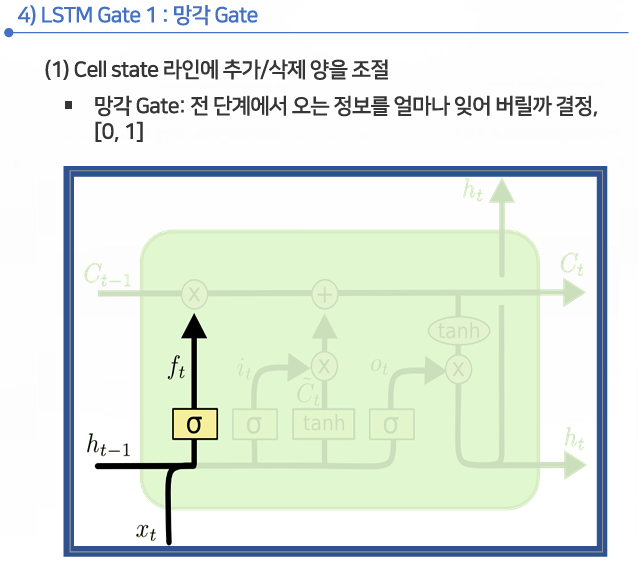

In [7]:
Image("img/day03_07.png", width=400)

> - 1은 과거의 정보를 기억, 0이면 잊어버린다.
> - 이전단계의 출력(ht-1)와 현 상태의 입력(Xt)을 합성 후 시그머이드 합성을 해서 올린다.

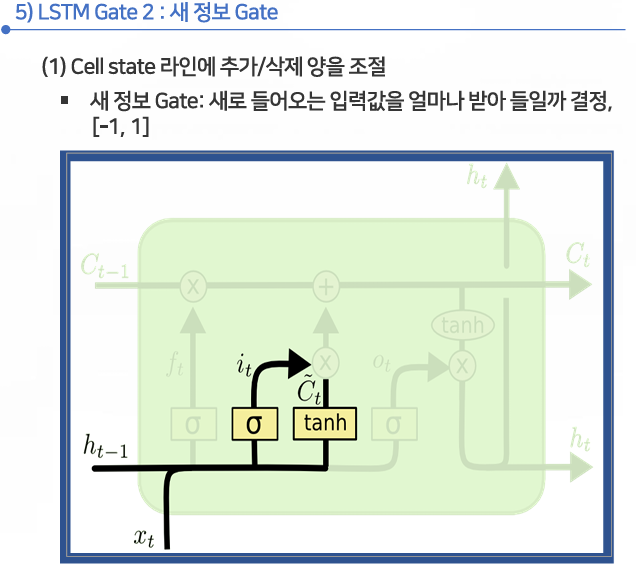

In [8]:
Image("img/day03_08.png", width=400)

> - 시그모이드 활성화 함수(𝜎) 를 사용하여 0과 1사이의 값을 출력
> - tanh ( 하이퍼볼릭 탄젠트) : 출력 범위 -1 에서 1 사이의 값을 가진다.
> -  매우 큰 양수 일때 1에 가깝고,  매우 큰 음수일 때는 -1에 가깝다.

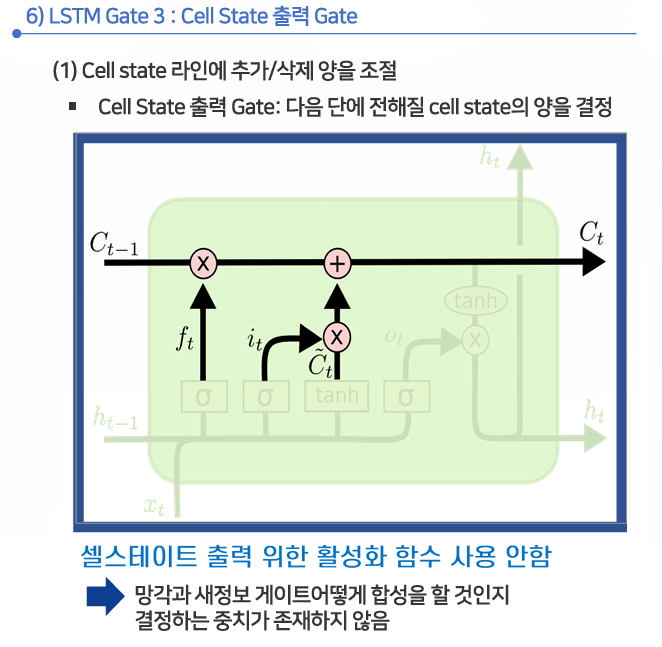

In [9]:
Image("img/day03_09.png", width=400)

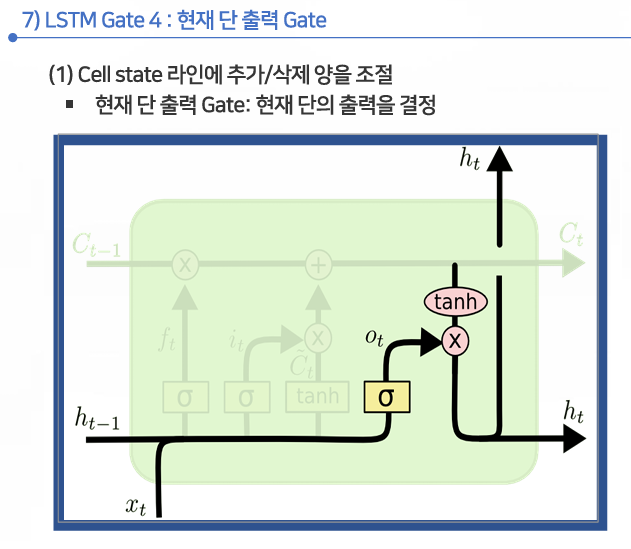

In [10]:
Image("img/day03_10.png", width=400)

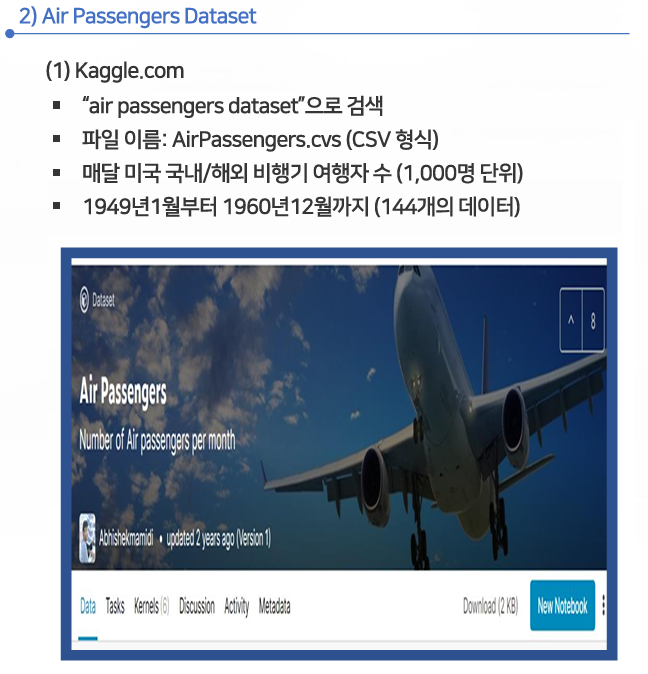

In [11]:
Image("img/day03_11.png", width=600)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import InputLayer, Dense
from keras.layers import LSTM

# 하이퍼 파라미터
MY_PAST = 12          # 시계열에서 12개의 입력값으로 사용 ( 12개월 여행자 수)
MY_SPLIT = 0.8        # 학습량(80%)
MY_UNIT = 300         # LSTM 내부구조의 차원수 ( 각 단에서 출력하는 데이터의 수, 다음 단으로 넘기는 수)
MY_SHAPE = (MY_PAST, 1)

MY_EPOCH = 300   # 반복 학습의 수
MY_BATCH = 64    # 병령 계산 데이의 수

# np의 내용을 소수점 3자리 까지만 처리하자
np.set_printoptions(precision=3) 

### 1. 데이터 파일 읽기

In [13]:
# 결과는 pandas의 데이터 프레임 형식
# csv의 첫 행이 컬러명이 아닌 경우 : header=None, 컬럼명이 있는 경우 : header=None 생략
raw = pd.read_csv("data/airline.csv", header=None, usecols=[1])

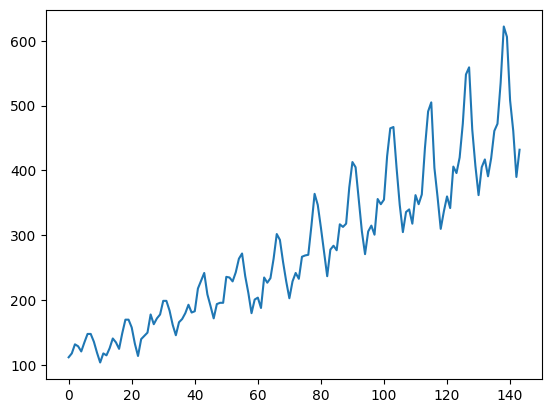

In [14]:
plt.plot(raw)
plt.show()

In [15]:
# 데이터 원본 출력
print(raw.head())

# 데이터 원본 통계
print(raw.describe())

     1
0  112
1  118
2  132
3  129
4  121
                1
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


### 2. 데이터 정규화

> -  MinMax 데이터 정규화 : 데이터의 모든 숫자를 0과 1사이의 값으로 변환

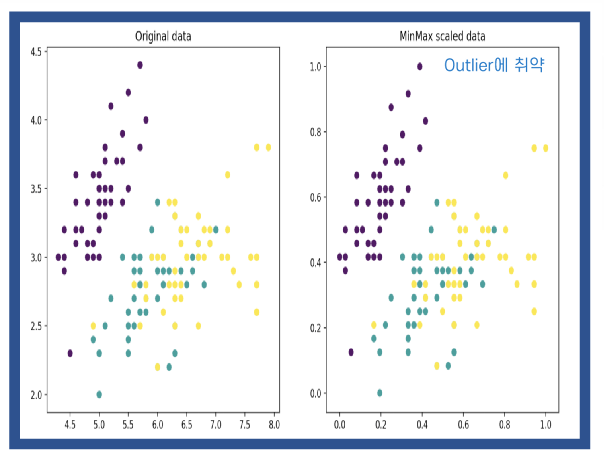

In [16]:
Image("img/day03_13.png",width=600)

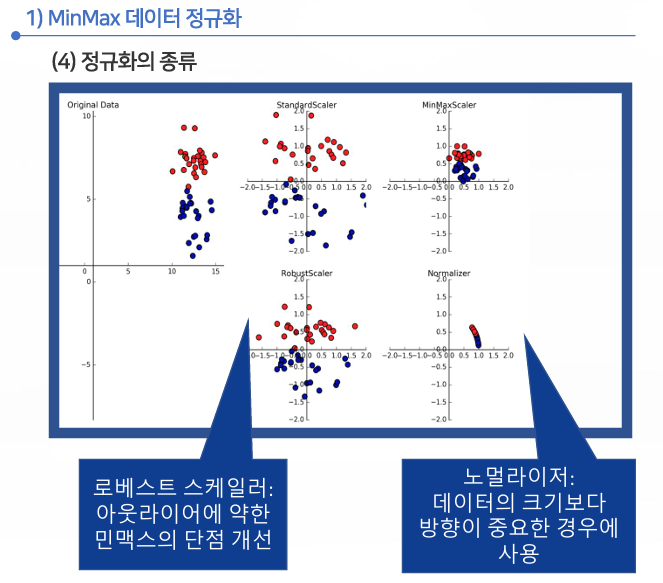

In [17]:
Image("img/day03_14.png",width=600)

In [18]:
scaler = MinMaxScaler()
s_data = scaler.fit_transform(raw)

# s_data는 DataFrame이 아니고 ndarray 형식으로 변경된다.
print(type(raw))
print(type(s_data))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [19]:
# 데이터 프레임으로 다시 만들자
df = pd.DataFrame(s_data)
print(df.head(20))
print(df.describe())

           0
0   0.015444
1   0.027027
2   0.054054
3   0.048263
4   0.032819
5   0.059846
6   0.084942
7   0.084942
8   0.061776
9   0.028958
10  0.000000
11  0.027027
12  0.021236
13  0.042471
14  0.071429
15  0.059846
16  0.040541
17  0.086873
18  0.127413
19  0.127413
                0
count  144.000000
mean     0.340345
std      0.231595
min      0.000000
25%      0.146718
50%      0.311776
75%      0.495174
max      1.000000


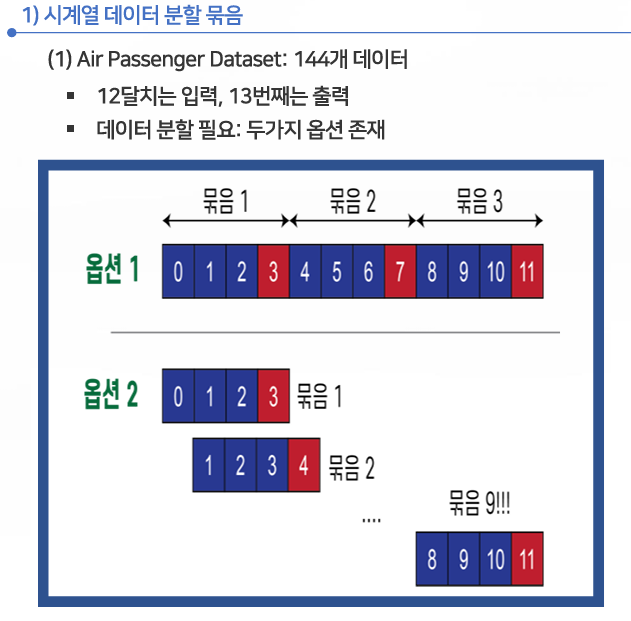

In [20]:
Image("img/day03_15.png", width=600)

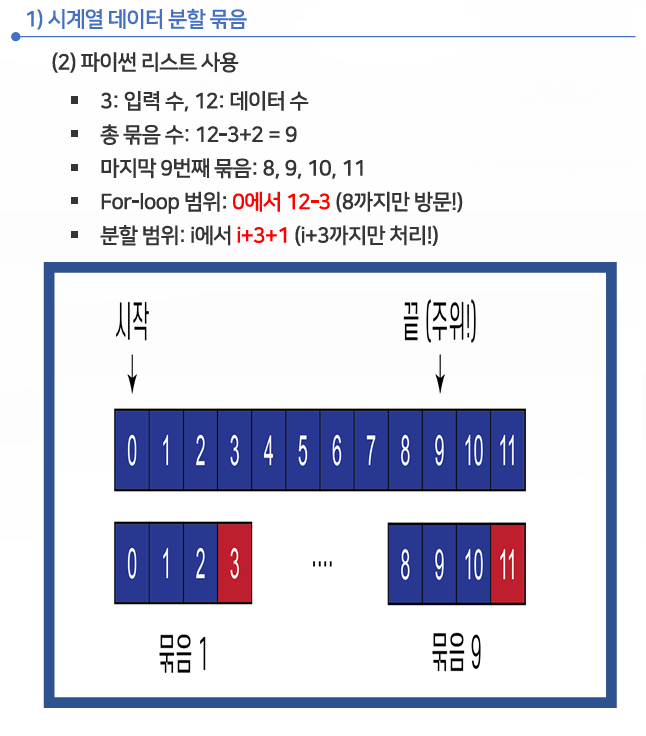

In [21]:
Image("img/day03_16.png", width=600)

In [22]:
## 13개 묶음 (12달치 입력, 13번째 출력)으로 데이터 분할 (144개 월의 데이터)
## 시계열은 데이터 내용도 중요하지만 시점(순서)도 중요하다.(데이터순서를 그대로 사용)

bundle = []
for i in range(len(s_data) - MY_PAST):
    bundle.append(s_data[i: i+MY_PAST+1])
   

In [23]:
print('13개의 묶음 수 : ',  len(bundle))
print(bundle[0])
print(bundle[1])

13개의 묶음 수 :  132
[[0.015]
 [0.027]
 [0.054]
 [0.048]
 [0.033]
 [0.06 ]
 [0.085]
 [0.085]
 [0.062]
 [0.029]
 [0.   ]
 [0.027]
 [0.021]]
[[0.027]
 [0.054]
 [0.048]
 [0.033]
 [0.06 ]
 [0.085]
 [0.085]
 [0.062]
 [0.029]
 [0.   ]
 [0.027]
 [0.021]
 [0.042]]


In [24]:
# 현재는 리스트
print(type(bundle))

bundle = np.array(bundle)
print(type(bundle), bundle.shape)


<class 'list'>
<class 'numpy.ndarray'> (132, 13, 1)


In [27]:
print(bundle)

[[[0.015]
  [0.027]
  [0.054]
  ...
  [0.   ]
  [0.027]
  [0.021]]

 [[0.027]
  [0.054]
  [0.048]
  ...
  [0.027]
  [0.021]
  [0.042]]

 [[0.054]
  [0.048]
  [0.033]
  ...
  [0.021]
  [0.042]
  [0.071]]

 ...

 [[0.585]
  [0.498]
  [0.581]
  ...
  [0.969]
  [0.78 ]
  [0.689]]

 [[0.498]
  [0.581]
  [0.604]
  ...
  [0.78 ]
  [0.689]
  [0.552]]

 [[0.581]
  [0.604]
  [0.554]
  ...
  [0.689]
  [0.552]
  [0.633]]]


In [25]:
## 13 묶음 중 앞 12개 입력, 뒤에 1개 출력
X_data = bundle[:, 0:MY_PAST]
Y_data = bundle[:, -1]

In [30]:
# 데이터를 학습용과 평가용으로 분할 
split = int(len(bundle) * MY_SPLIT)
X_train = X_data[:split]
X_test = X_data[split:]

Y_train = Y_data[:split]
Y_test = Y_data[split:]


print(X_train.shape)
print(X_test.shape)

print(Y_train.shape)
print(Y_test.shape)

(105, 12, 1)
(27, 12, 1)
(105, 1)
(27, 1)


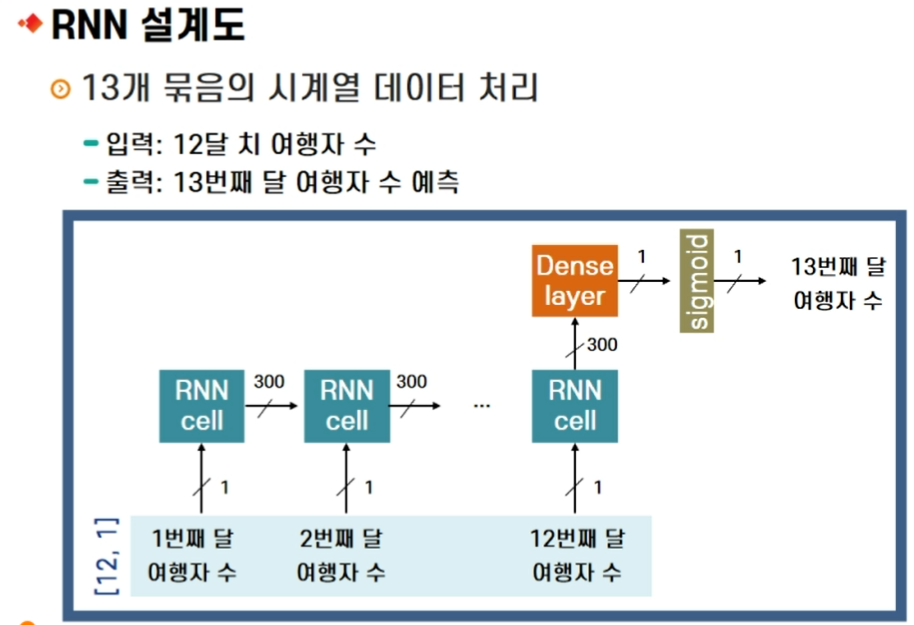

In [31]:
Image("img/day03_17.png", width=600)

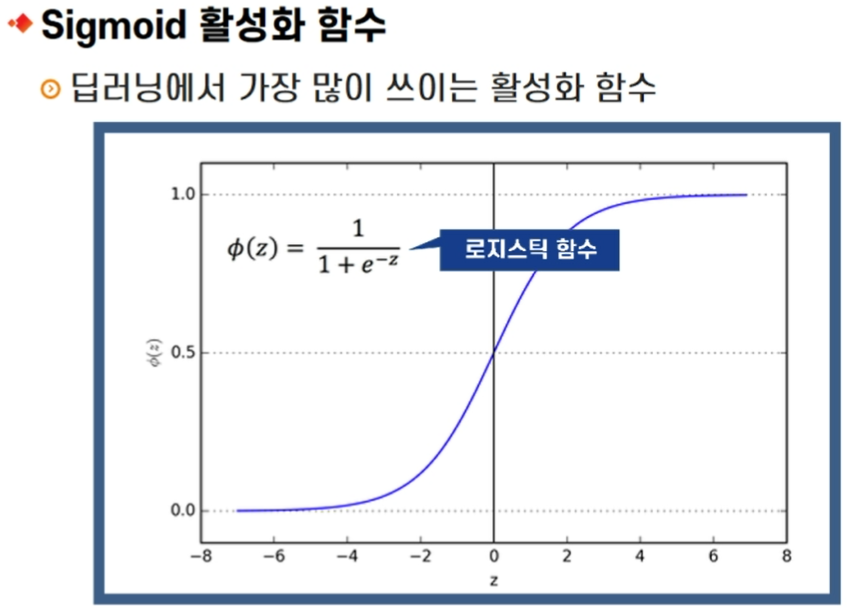

In [32]:
Image("img/day03_18.png", width=600)

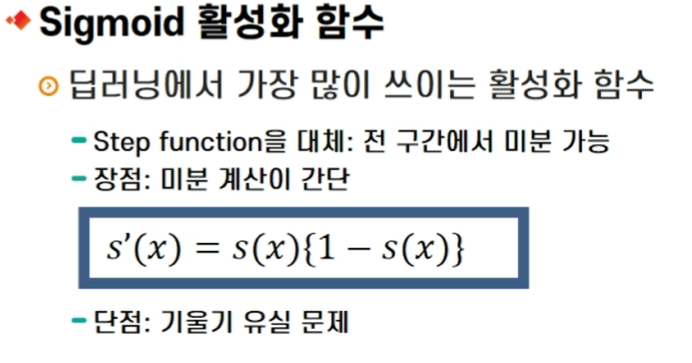

In [34]:
Image("img/day03_19.png", width=600)

In [35]:
#### 인공 신경망 구현

### RNN 구현
## 주의) Keras의 RNN은 2차원 데이터만 입력 허용한다. 

model = Sequential()
model.add(InputLayer(shape=MY_SHAPE))
model.add(LSTM(MY_UNIT))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 300)                 │         362,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             301 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 362,701 (1.38 MB)

 Trainable params: 362,701 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
###### 인공 신경망 학습

# 컴파일에서 최적화 함수와 손실 함수 지정
model.compile(optimizer="rmsprop", loss="mse")

begin = time()
print("학습시작")

model.fit(X_train, Y_train, epochs=MY_EPOCH, batch_size = MY_BATCH, verbose=0)

end = time()
print ("총시간 : {:.1f}초" .format(end-begin))

학습시작
총시간 : 23.7초


In [39]:
#### 인공 신경망 평가
loss = model.evaluate(X_test, Y_test, verbose=0)
print("최종 MSE 손실값 : {:.3f}" .format(loss))

최종 MSE 손실값 : 0.017


In [40]:
## 예측
pred  = model.predict(X_test)
pred = scaler.inverse_transform(pred)
pred = pred.flatten().astype(int)
print("예측 결과 원본 : ", pred)

## 정답
truth = scaler.inverse_transform(Y_test)
truth = truth.flatten().astype(int)
print("정답 원본 : ", truth)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
예측 결과 원본 :  [367 336 326 319 324 345 368 397 429 446 448 417 380 347 339 342 350 370
 385 413 440 461 469 448 414 386 370]
정답 원본 :  [359 310 337 360 342 406 396 420 472 548 559 463 407 362 405 417 391 419
 461 472 535 622 606 508 461 390 432]


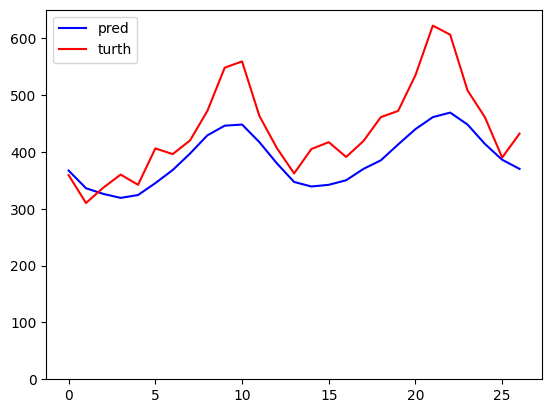

In [41]:
axes = plt.gca()
axes.set_ylim([0, 650])

sns.lineplot(data=pred, label="pred", color="blue")
sns.lineplot(data=truth, label="turth", color="red")

plt.show()